## Robust Mean - Variance Portfolio

The robust portfolio optimization problem is a variant of traditional portfolio optimization problem. The objective is to allocate a total investment amount across different assets to maximize the portfolio's expected return, while ensuring a very low probability (e.g., 0.5%) that the actual return falls below this expected value. This approach addresses the inherent uncertainty in portfolio returns, making it a robust optimization problem.

In the example taken from Bertsimas and Den Hertog (2015) [1], Section 3.4, we have $n = 200$ assets. Let $r_i$ denote the return of the $i$-th asset. The return on Asset #200 $r_{n}=1.05$ has zero variability. The returns of the remaining assets $r_i$, $\forall i \in [n - 1]$, are random variables taking values in the intervals $[\mu_i - \Sigma_i ,\mu_i + \Sigma_i  ]$. The vectors $\mathbf{\mu}$ and $\Sigma$ are defined as

$$ \mu_i = 1.05 + \frac{0.3\left(n - i\right)}{n - 1} , \space \Sigma_i = 0.05 + \frac{0.6\left(n - i\right)}{n - 1}, \space \forall i \in [n - 1]. $$



To solve this problem, we first import the required packages and generate the data. 

In [2]:
import lropt
import cvxpy as cp
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

In [ ]:
N = 200
GUARANTEED_RETURN = 1.05
b2 = 0.3
b3 = 0.05
b4 = 0.6
P = 2

#Define mu
mu = np.zeros(N - 1)
for i in range(N - 1):
    mu_i = GUARANTEED_RETURN + b2 * (N - i) / (N- 1)
    mu[i] = mu_i  

#Define sigma
sigma = np.zeros(N - 1)
for i in range(N - 1):
    sigma_i = b3 + b4 * (N - i) / (N - 1)
    sigma[i] = sigma_i 


## Formulation

The problem we want to solve is the uncertain linear optimization problem:

$$
\begin{array}{ll}
\text{maximize} & \mathbf{t} \\
\text{subject to} & \mathbf{\mu}^T \mathbf{x} + \Sigma^T \mathbf{x} + r_nx_{n} \geq \mathbf{t} \\
                  & \mathbf{1}^T \mathbf{x}= 1 \\
                  & \mathbf{x} \geq \mathbf{0}

\end{array}
$$

where $ x_i $ is the capital to be invested in asset $i$. The guarenteed yearly return is 1.05.



In this problem, the uncertain data are the returns $r_i = \mu_i + \sigma_i z_i,\, i \in [199]$ where $z$ is a vector of independant random variables with zero mean varying in the segments $[-1, 1]$. The robust counterpart to the uncertain linear optimization problem is:

$$
\begin{array}{ll}
\text{maximize} & \mathbf{t} \\
\text{subject to} & (\mathbf{\mu} + \Sigma^T \mathbf{z})^T\mathbf{x} + r_nx_{n} \geq \mathbf{t} , \quad \forall z \in \mathcal{Z} \\
                  & \mathbf{1}^T \mathbf{x}= 1 \\
                  & \mathbf{x} \geq \mathbf{0}

\end{array}
$$

for a variety of uncertainty sets $ \mathcal{Z} $. 

## Numerical Example

In the following snippet, we solve this problem using  Ellipsoidal and Budget uncertainty sets and compare the results.


In [4]:
names = ['Ellipsoidal', 'Budget']
rho_values = np.linspace(0.1, 2.0, 10)  # Range of rho values

results = []


for rho in rho_values:
    uncertainty_sets = [
        lropt.Ellipsoidal(rho=rho, a=np.diag(sigma), b=mu),
        lropt.Budget(rho1=rho, rho2=rho, b=mu, a=np.diag(sigma))
    ]
    
    for uc_index, uc in enumerate(uncertainty_sets):
        t = cp.Variable()
        x = cp.Variable(N, nonneg=True)
        z = lropt.UncertainParameter(N - 1, uncertainty_set=uc)


        constraints = [
            z @ x[:(N-1)] + GUARANTEED_RETURN * x[-1] >= t,
            cp.sum(x) == 1
        ]

        objective = cp.Maximize(t)
        prob = lropt.RobustProblem(objective, constraints)
        prob.solve()

        optimal_allocation = x.value
        optimal_return = float(t.value)


        cov_matrix = np.diag(sigma ** 2)
        variance = np.dot(optimal_allocation[:(N-1)].T, np.dot(cov_matrix, optimal_allocation[:(N-1)]))
        risk = np.sqrt(variance)

        results.append({
            'rho': rho,
            'uncertainty_set': names[uc_index],
            'return': optimal_return,
            'risk': risk
        })

/Users/mj5676/Desktop/miniconda3/envs/lropt_v3/lib/python3.12/site-packages/scipy/sparse/_index.py:134: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray_sparse(i, j, x)
/Users/mj5676/Desktop/miniconda3/envs/lropt_v3/lib/python3.12/site-packages/cvxpy/utilities/torch_utils.py:61: UserWarning: torch.sparse.SparseTensor(indices, values, shape, *, device=) is deprecated.  Please use torch.sparse_coo_tensor(indices, values, shape, dtype=, device=). (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/utils/tensor_new.cpp:643.)
  return torch.sparse.FloatTensor(i, v, torch.Size(value_coo.shape)).to(dtype)


## Plot

The following code creates a graph of the tradeoff curve of risk and return. This was created by simulating the risk and calculating the return using the optimal allocations given by the solution of the robust problem. It is calculated over a range of values of $\rho$.

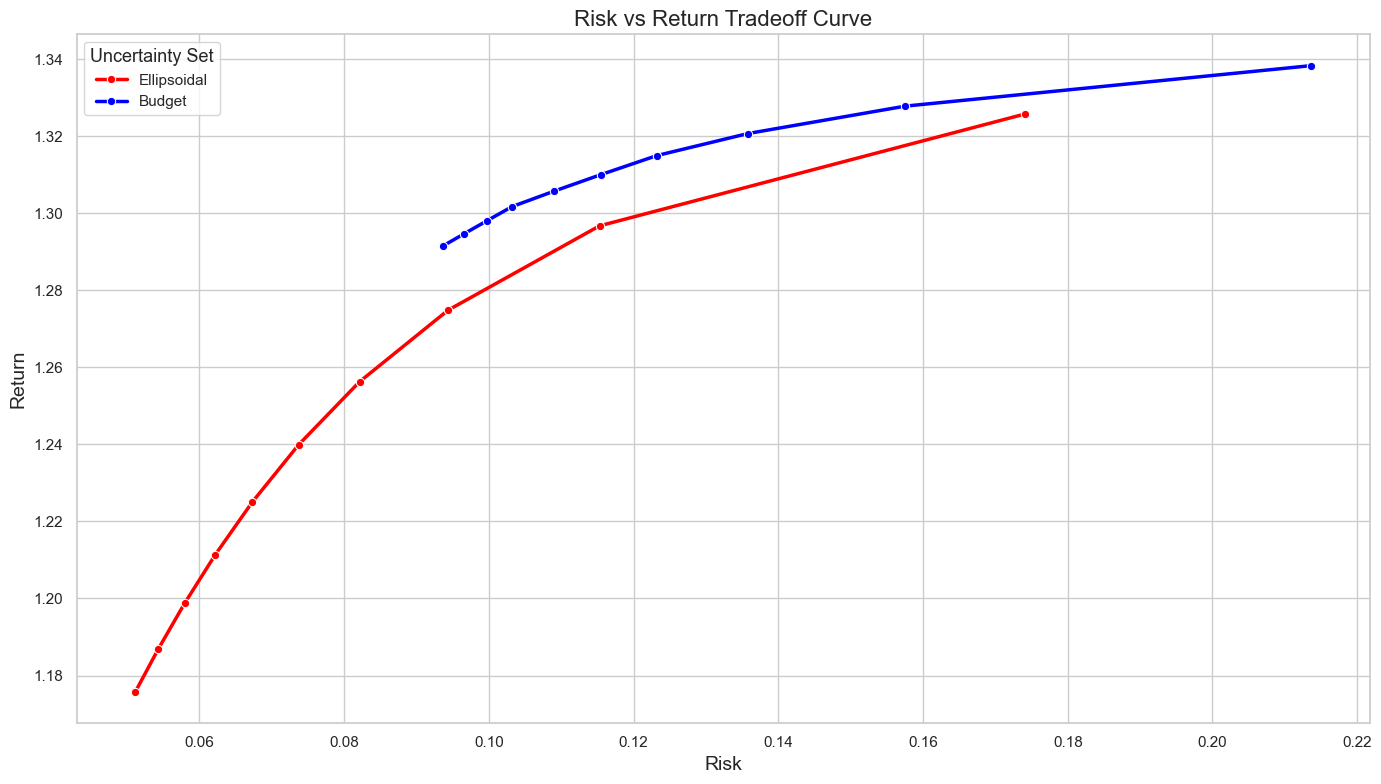

In [ ]:
df_results = pd.DataFrame(results)


plt.figure(figsize=(14, 8))
sns.set_theme(style="whitegrid")
colors = ['red', 'blue']


sns.lineplot(
    data=df_results,
    x='risk',
    y='return',
    hue='uncertainty_set',
    palette=colors,
    marker='o',
    linewidth=2.5
)

plt.xlabel('Risk', fontsize=14)
plt.ylabel('Return', fontsize=14)
plt.title('Risk vs Return Tradeoff Curve', fontsize=16)
plt.legend(title='Uncertainty Set', title_fontsize='13', fontsize='11')
plt.grid(True)
plt.tight_layout()
plt.show()

# References

1. Bertsimas, Dimitris, and Dick Den Hertog. Robust and Adaptive Optimization. [Dynamic Ideas LLC], 2022.